# Analyse spectrale et aliasing

Objectifs :
- Générer des signaux temporels (somme de cosinus)
- Échantillonner avec une fréquence `fs` et un nombre d’échantillons `N`
- Calculer la FFT et tracer le **spectre linéaire unilatéral** (amplitude)
- Modifier `fs` (20 kHz → 8 kHz → 20 kHz à 1 kHz) et observer **l’aliasing**


## Imports et réglages
On charge NumPy/Matplotlib et Path pour gérer les dossiers de sauvegarde.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


## Fonctions utilitaires
Une FFT "one-sided" pour retrouver l'amplitude réelle des sinusoïdes, et un helper pour tracer le signal temporel et son spectre.


In [9]:
def one_sided_amplitude_spectrum(x, fs):
    """
    Retourne (f, |X(f)|) en amplitude unilatérale.
    - x : signal échantillonné (N points)
    - fs : fréquence d'échantillonnage (Hz)

    Remarque :
    - Pour un cosinus A*cos(2π f0 t), le pic sera ~A (si f0 est alignée sur un bin FFT).
    """
    N = len(x)
    X = np.fft.rfft(x)
    f = np.fft.rfftfreq(N, d=1/fs)

    mag = np.abs(X) / N
    if len(mag) > 2:
        mag[1:-1] *= 2  # passage de deux-côtés -> un-côté (sauf DC et shannon)
    return f, mag


def plot_time_and_spectrum(t, x, fs, title, fmax=None, tmax=None, savepath=None):
    f, mag = one_sided_amplitude_spectrum(x, fs)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ax_t, ax_f = axes

    ax_t.plot(t, x)
    ax_t.set_xlabel("Time (s)")
    ax_t.set_ylabel("Amplitude")
    ax_t.set_title(f"{title} — Time domain (fs={fs/1000:.1f} kHz, N={len(x)})")
    if tmax is not None:
        ax_t.set_xlim(0, tmax)
    ax_t.grid(True, alpha=0.3)

    ax_f.stem(f, mag, basefmt=" ")
    ax_f.set_xlabel("Frequency (Hz)")
    ax_f.set_ylabel("|X(f)| (one-sided amplitude)")
    ax_f.set_title(f"{title} — Spectrum (FFT)")
    if fmax is not None:
        ax_f.set_xlim(0, fmax)
    ax_f.grid(True, alpha=0.3)

    fig.tight_layout()
    if savepath is not None:
        fig.savefig(str(savepath) + ".png", dpi=160, bbox_inches="tight")


## Définition des sinusoïdes
$x_1$, $x_2$ et $x$ comme dans le sujet : 1 kHz, 2 kHz et 8 kHz.


In [10]:
f1, f2, f3 = 1000.0, 2000.0, 8000.0  # Hz

def x1(t): return 1.0 * np.cos(2*np.pi*f1*t)
def x2(t): return x1(t) + 2.0 * np.cos(2*np.pi*f2*t)
def x(t):  return x2(t) + 5.0 * np.cos(2*np.pi*f3*t)


## Partie A — fs = 20 kHz, N = 1000
On échantillonne haut (shannon = 10 kHz) et on observe les raies à 1, 2 et 8 kHz.


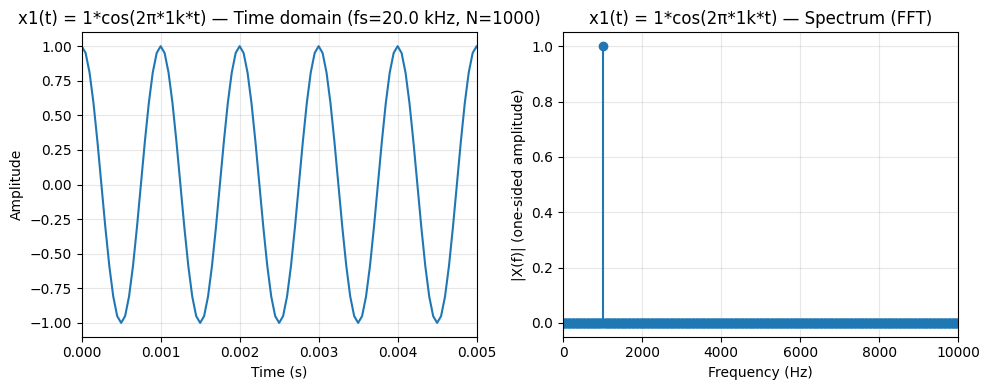

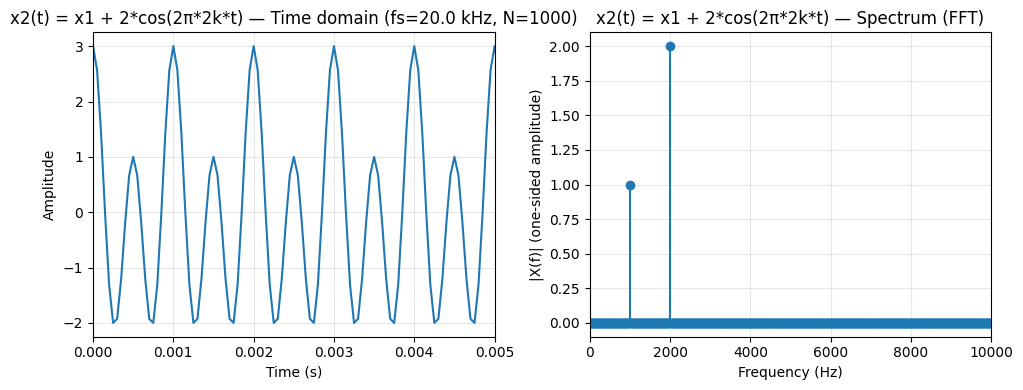

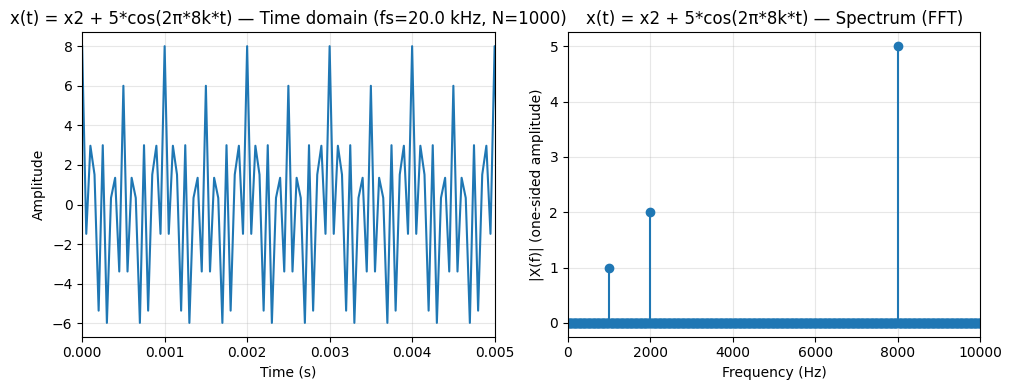

In [11]:
N = 1000
fs = 20000.0
t = np.arange(N) / fs

plot_time_and_spectrum(t, x1(t), fs, "x1(t) = 1*cos(2π*1k*t)", fmax=10000, tmax=0.005)
plot_time_and_spectrum(t, x2(t), fs, "x2(t) = x1 + 2*cos(2π*2k*t)", fmax=10000, tmax=0.005)
plot_time_and_spectrum(t,  x(t), fs, "x(t) = x2 + 5*cos(2π*8k*t)", fmax=10000, tmax=0.005)


## Partie B — fs = 8 kHz
shannon = 4 kHz : la composante 8 kHz se replie (alias) dans la bande observable.


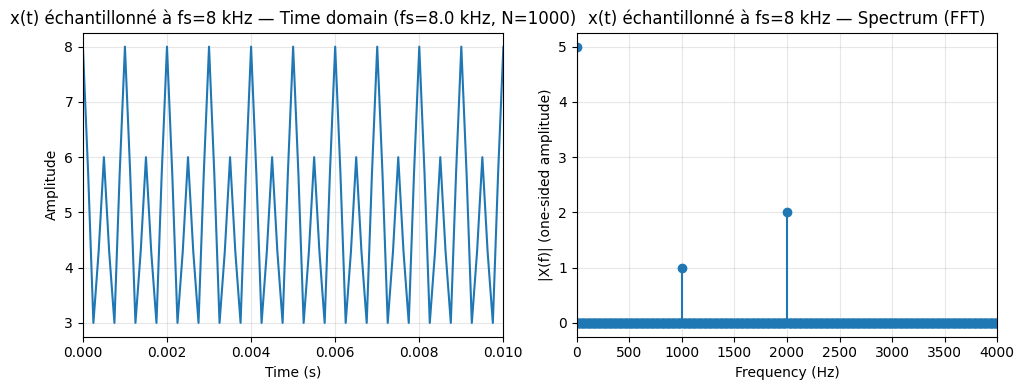

In [12]:
fs2 = 8000.0
t2 = np.arange(N) / fs2
plot_time_and_spectrum(t2, x(t2), fs2, "x(t) échantillonné à fs=8 kHz", fmax=4000, tmax=0.01)


## Partie C — balayage fs de 20 kHz à 1 kHz
On diminue fs par pas de 1 kHz, on observe le déplacement des pics (aliasing) et on enregistre les PNG.


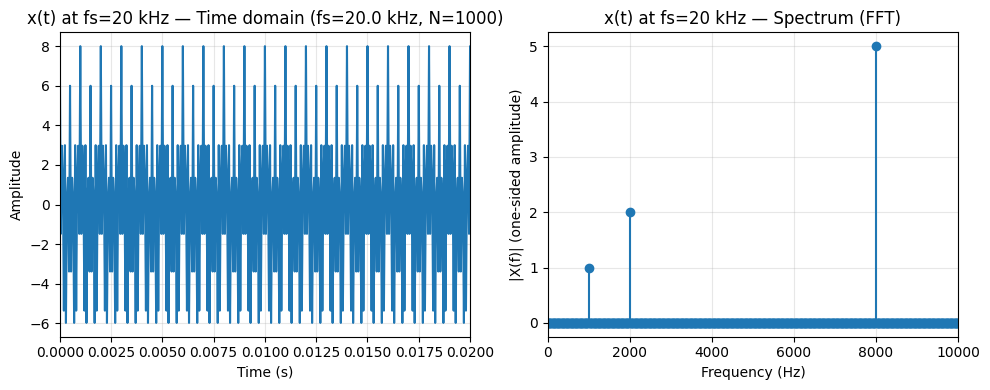

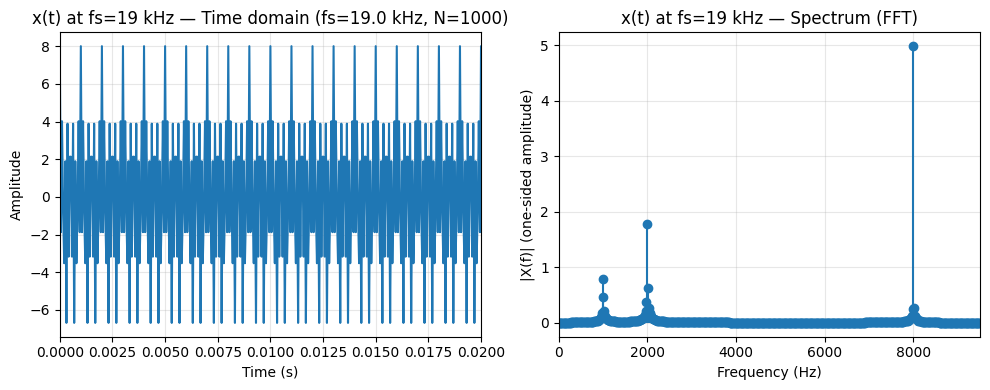

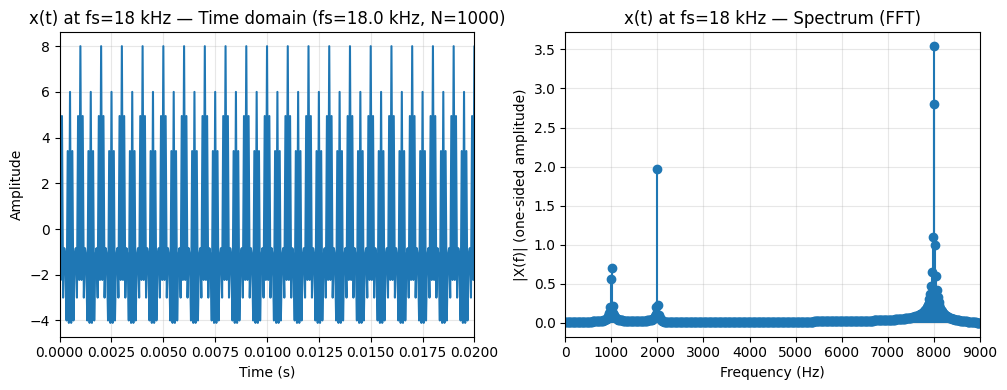

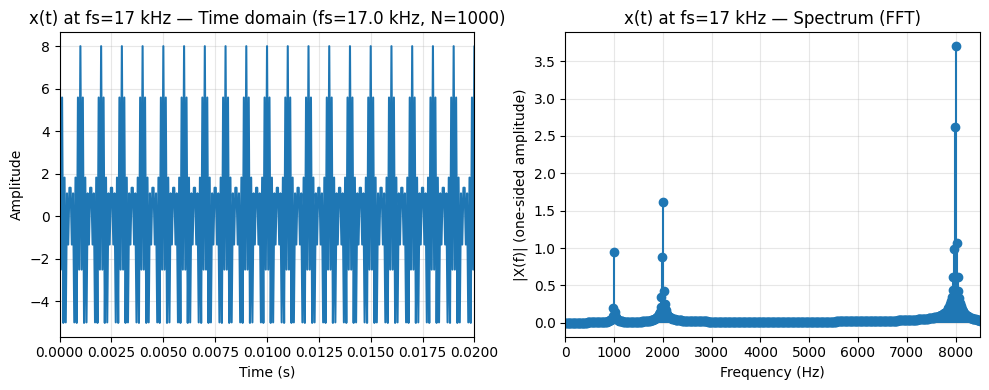

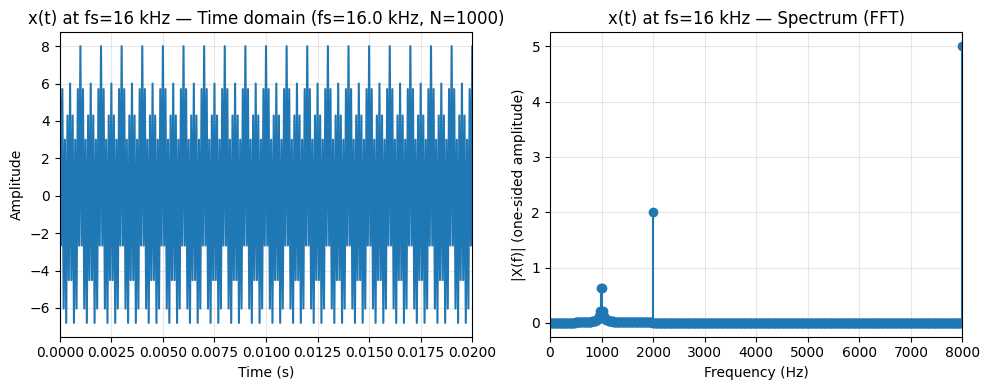

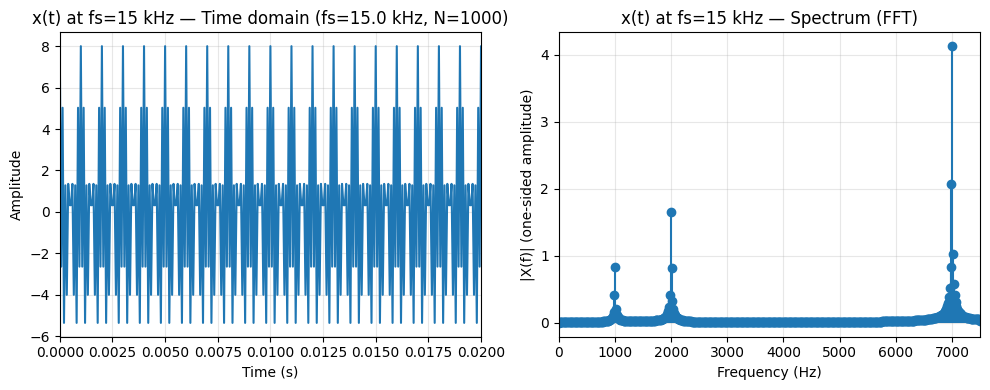

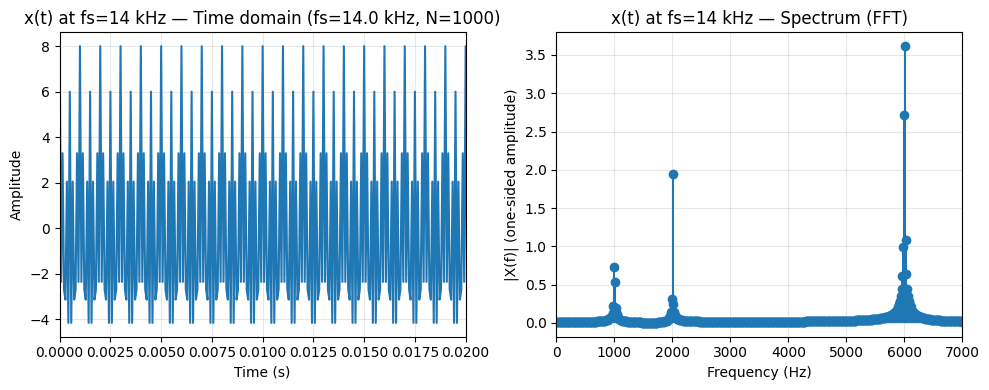

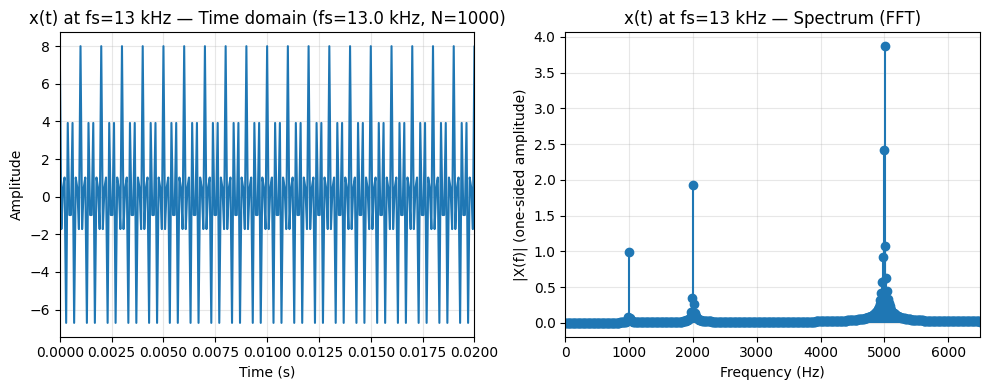

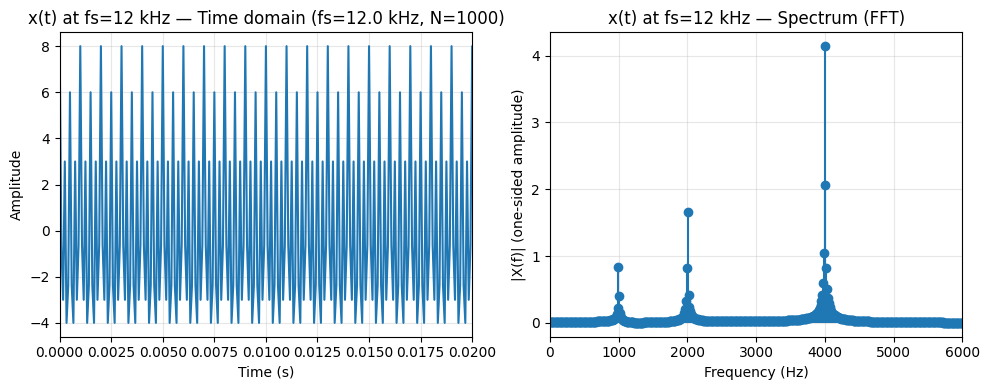

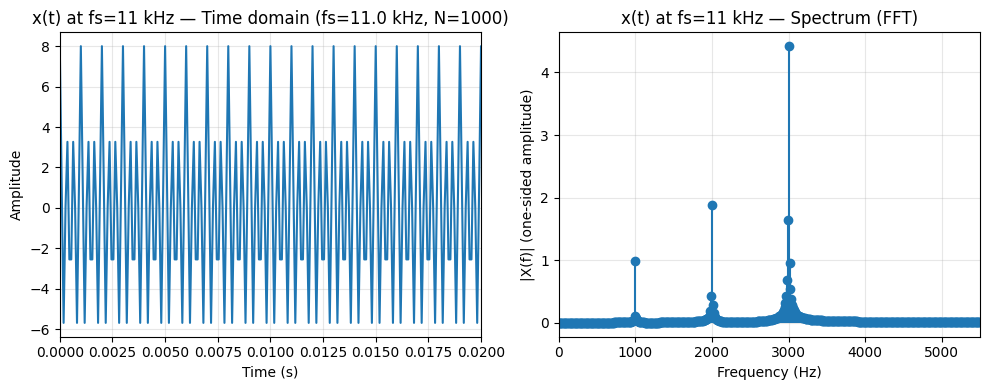

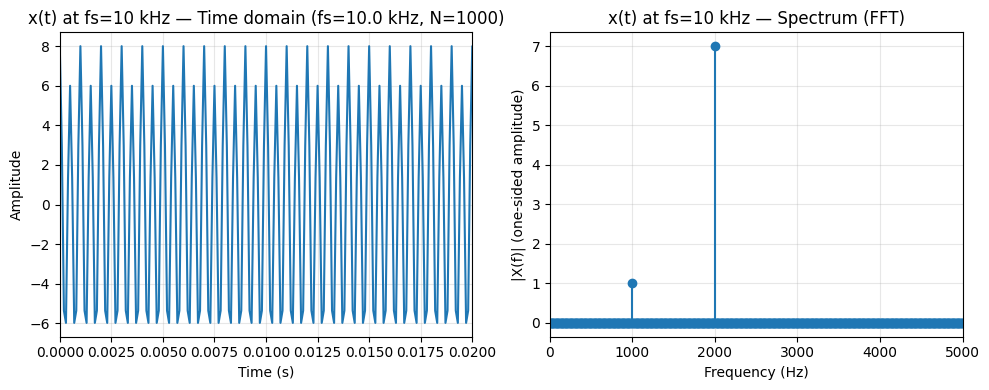

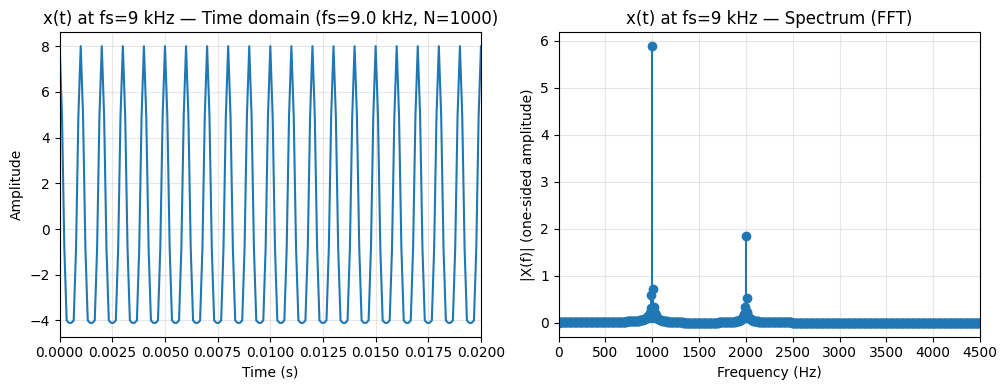

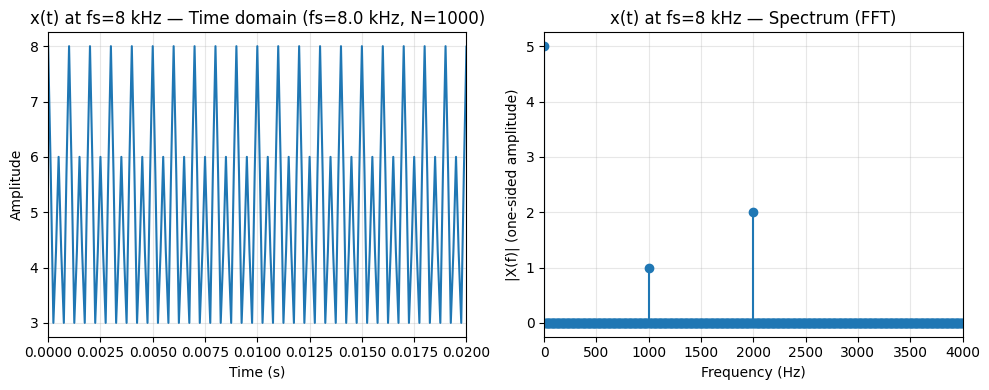

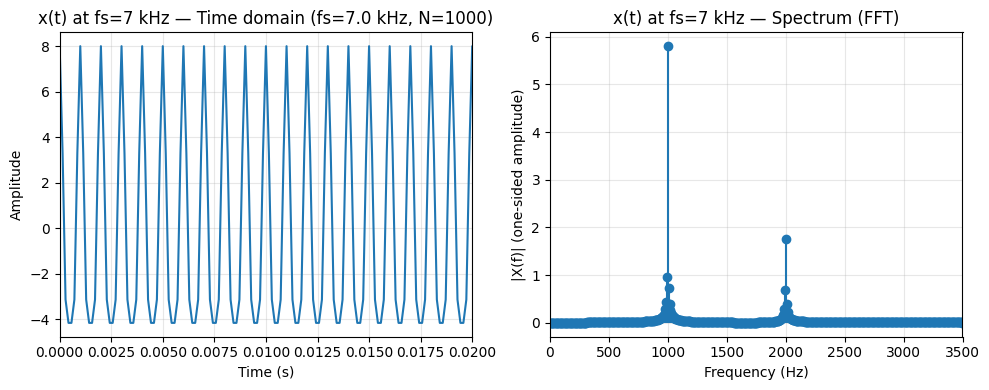

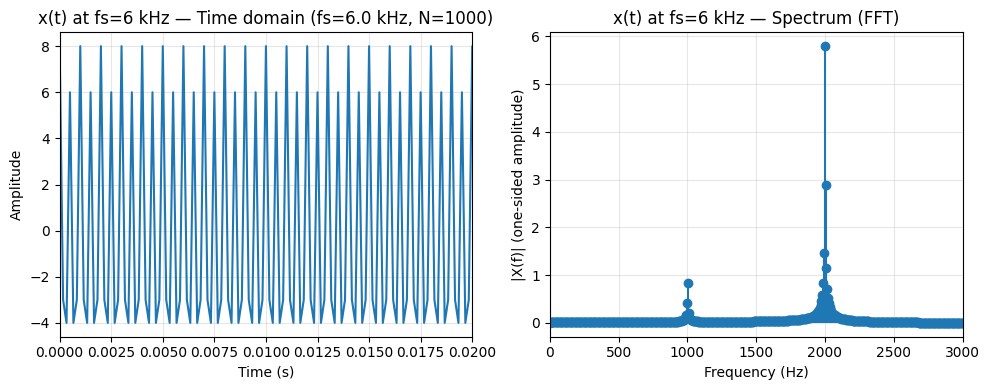

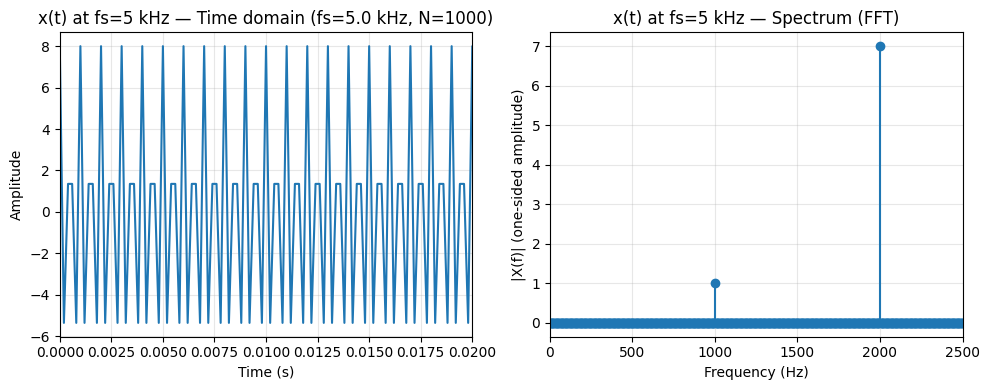

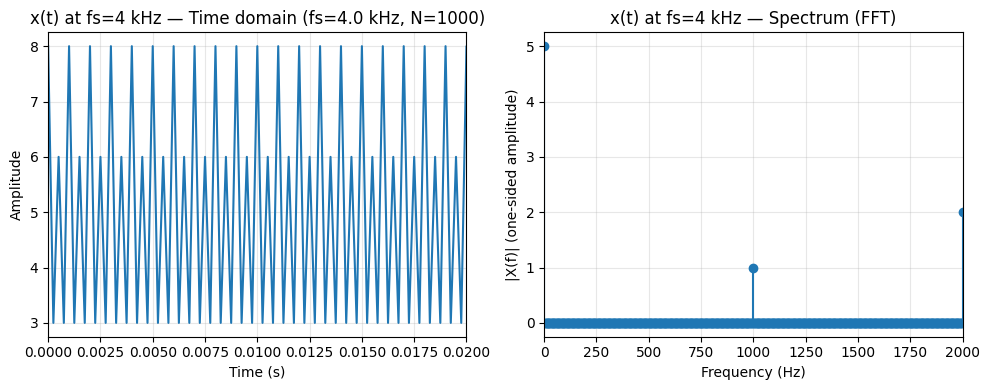

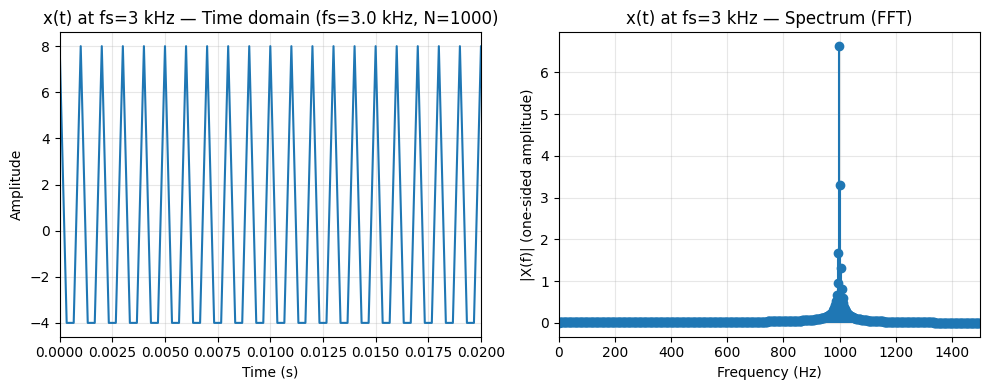

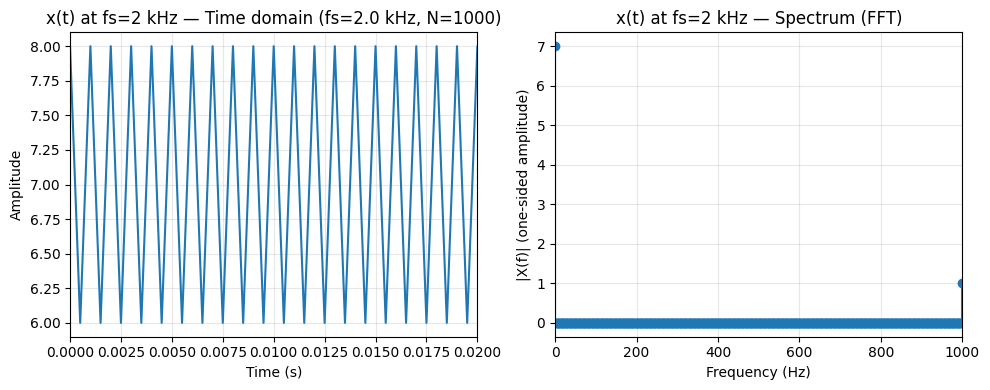

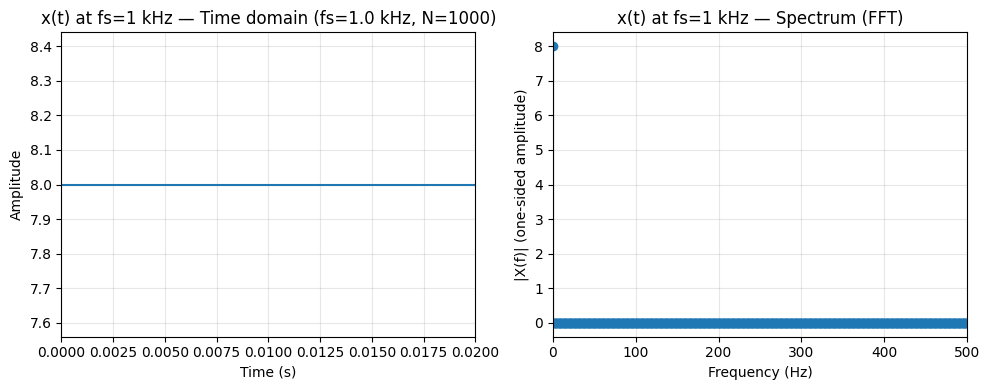

In [13]:
out_dir = Path("td2_figures")
out_dir.mkdir(exist_ok=True)

for fs_k in range(20, 0, -1):  # 20,19,...,1 kHz
    fs_loop = fs_k * 1000.0
    tt = np.arange(N) / fs_loop
    sig = x(tt)
    base = out_dir / f"x_fs_{fs_k:02d}kHz"
    plot_time_and_spectrum(tt, sig, fs_loop, f"x(t) at fs={fs_k} kHz",
                           fmax=fs_loop/2, tmax=min(0.02, N/fs_loop),
                           savepath=base)


## Optionnel — comparaison sinus / dent de scie
Une sinusoïde et une dent de scie à 10 Hz pour illustrer la répartition des harmoniques.


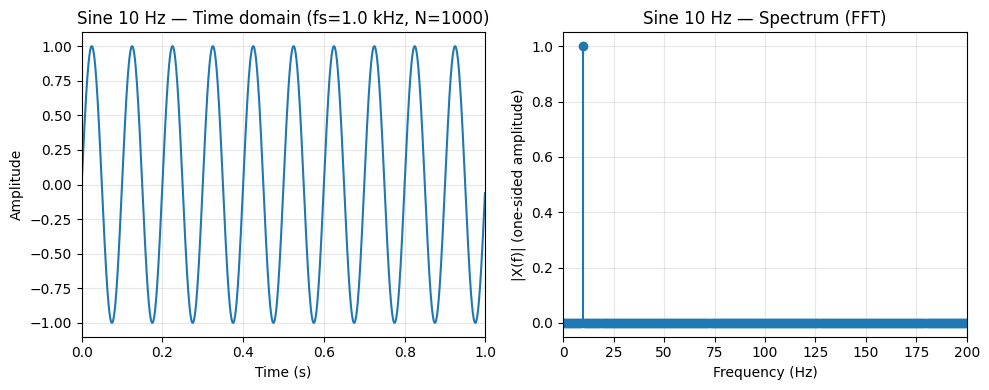

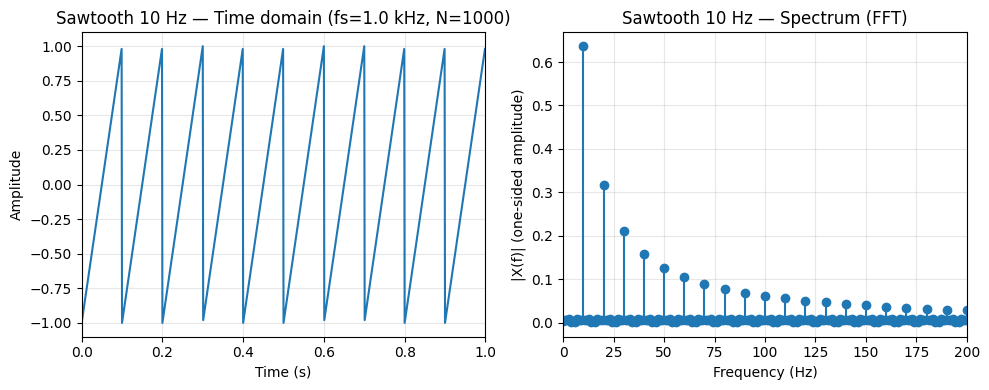

In [14]:
def sawtooth(t, f0, A=1.0):
    T = 1.0 / f0
    frac = (t / T) % 1.0
    return A * (2*frac - 1)

fs3 = 1000.0
t3 = np.arange(N) / fs3
plot_time_and_spectrum(t3, np.sin(2*np.pi*10*t3), fs3, "Sine 10 Hz", fmax=200, tmax=1.0)
plot_time_and_spectrum(t3, sawtooth(t3, 10, 1.0), fs3, "Sawtooth 10 Hz", fmax=200, tmax=1.0)

plt.show()
